# Uncertainty Sampling, classification example

In [1]:
%matplotlib inline
import numpy as np
import pandas
from plotnine import *
import sys
sys.path.append('..')
from plotting import plot_linear_classifier
from plotting import plot_classifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

## Active Learning with Uncertainty Sampling

In [2]:
def active_learn(num_samples, initial_sample, data, model):
    sample = initial_sample
    labeled = sample.index
    unlabeled = data.index[~data.index.isin(sample.index)]
    for i in range(0, num_samples+1):
        sample = data.loc[labeled]
        X = sample[['x','y']]
        y = sample.label
        model.fit(X,y)
        U = data.loc[unlabeled]    
        preda = model.predict_proba(U[['x','y']])[:,1]
        xstar_index = U.index[np.argmin(np.abs(preda-0.5))]
        labeled = labeled.insert(0,xstar_index)
        unlabeled = unlabeled.drop(xstar_index)
    return sample

## Toy dataset

In [3]:
data = pandas.read_pickle('../data/two_2dgaussians.pkl')

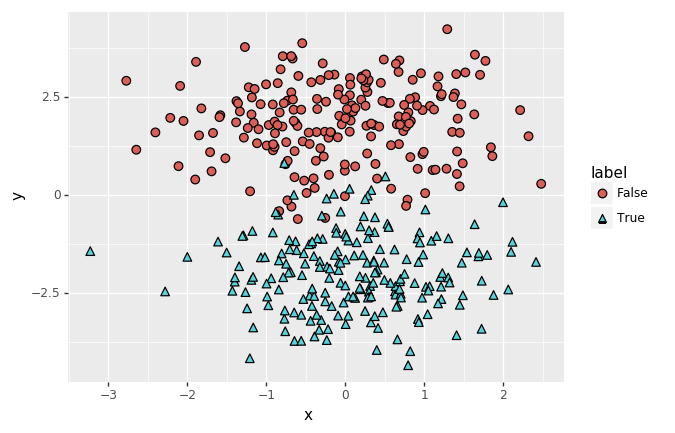

<ggplot: (-9223363272067390134)>

In [4]:
ggplot(data, aes(x='x', y='y', fill='label', shape='label'))+geom_point(size=3)

## Logistic regression with randomly drawn samples

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
sample = data.sample(30)
X = sample[['x','y']]
y = sample.label
lg = LogisticRegression()
lg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

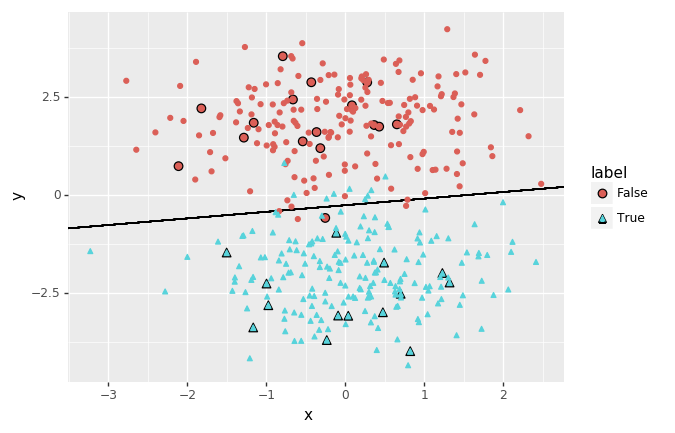

<ggplot: (-9223363272076390414)>

In [7]:
plot_linear_classifier(sample,data,lg)

In [8]:
test = pandas.read_pickle('../data/two_2dgaussians_test.pkl')
proba = lg.predict_proba(test[['x','y']])[:,1]
print("log loss: " + str(log_loss(test.label, proba)))
print("roc auc: " + str(roc_auc_score(test.label, proba)))

log loss: 0.10279259597058261
roc auc: 0.9988


## Active learning

In [9]:
initial_sample = data.sample(10)

In [10]:
sample = active_learn(20, initial_sample, data, lg)

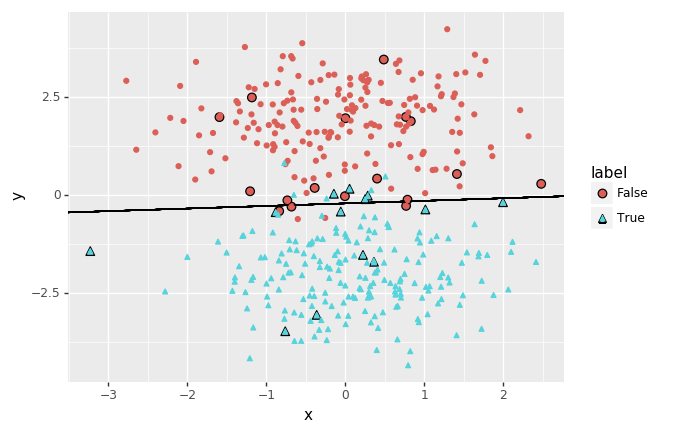

<ggplot: (8764773963170)>

In [11]:
plot_linear_classifier(sample,data,lg)

In [12]:
proba = lg.predict_proba(test[['x','y']])[:,1]
print("log loss: " + str(log_loss(test.label, proba)))
print("roc auc: " + str(roc_auc_score(test.label, proba)))

log loss: 0.11084156899324285
roc auc: 0.9991


## Skewed data

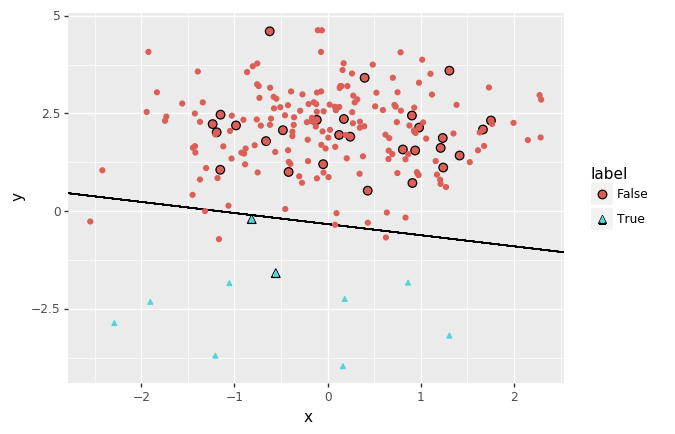

<ggplot: (8764773963121)>

In [13]:
data = pandas.read_pickle('../data/two_2dgaussians_skewed.pkl')
initial_sample = data[data.label==True].sample(1)
sample = initial_sample.append(data.sample(29))
X = sample[['x','y']]
y = sample.label
lg = LogisticRegression()
lg.fit(X,y)
plot_linear_classifier(sample,data,lg)

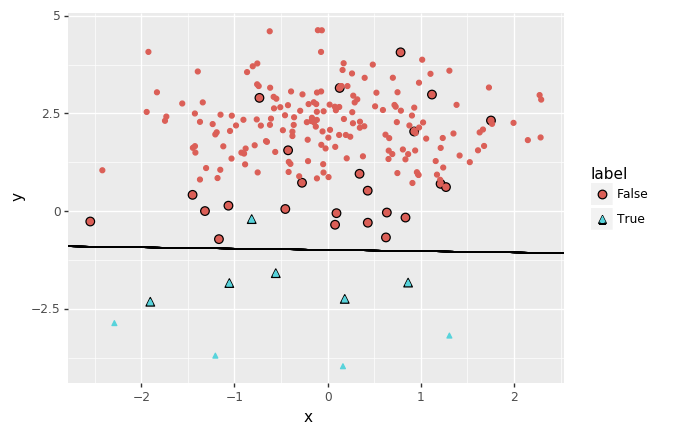

<ggplot: (8764773911893)>

In [14]:
initial_sample = data[data.label==True].sample(1)
initial_sample = initial_sample.append(data.sample(9))
sample = active_learn(20, initial_sample, data, lg)
plot_linear_classifier(sample,data,lg)

## Active learning with outliers

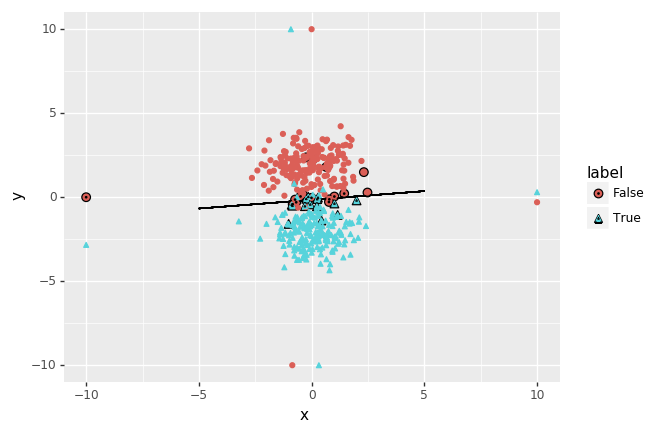

<ggplot: (8764773965646)>

In [15]:
data = pandas.read_pickle('../data/two_2dgaussians_with_outliers.pkl')
initial_sample = data.sample(10)
sample = active_learn(20, initial_sample, data, lg)
labeled_initial = initial_sample.index
selected = data.loc[sample.index.difference(labeled_initial)]
plot_linear_classifier(sample,data,lg)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Toy dataset 2

In [16]:
data = pandas.read_pickle('../data/three_2dgaussians.pkl')

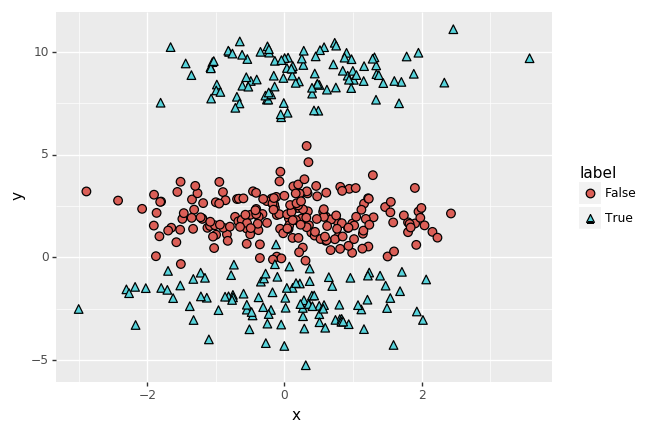

<ggplot: (8764773845722)>

In [17]:
ggplot(data, aes(x='x', y='y', fill='label', shape='label'))+geom_point(size=3)

## Random Forest with randomly drawn samples

In [18]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(n_estimators=100, max_features=2)    

In [19]:
sample = data.sample(40)
X = sample[['x','y']]
y = sample.label
tree.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

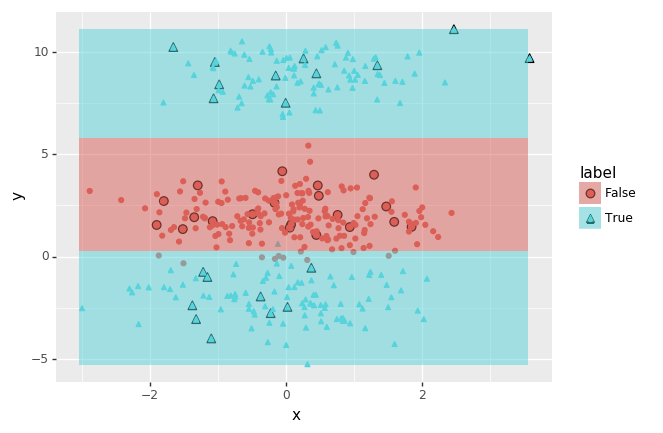

<ggplot: (8764772764024)>

In [20]:
plot_classifier(sample, data, tree)

## Active learning

In [21]:
initial_sample = data.sample(20)
labeled_initial = sample.index

### Initial model

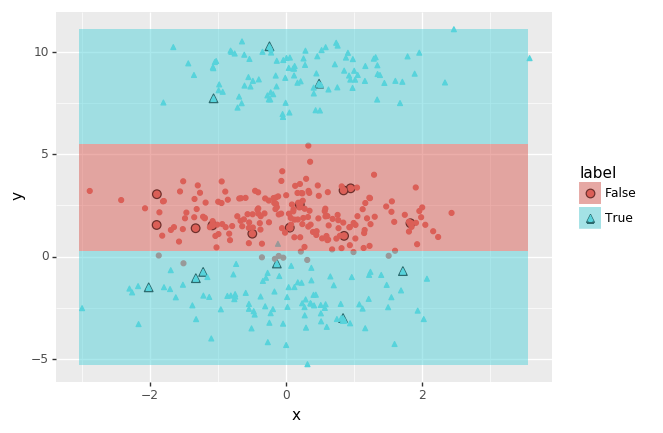

<ggplot: (-9223363272082010771)>

In [22]:
X = initial_sample[['x','y']]
y = initial_sample.label
tree.fit(X,y)
plot_classifier(initial_sample, data, tree)

### After active learning

In [23]:
sample = active_learn(20, initial_sample, data, tree)

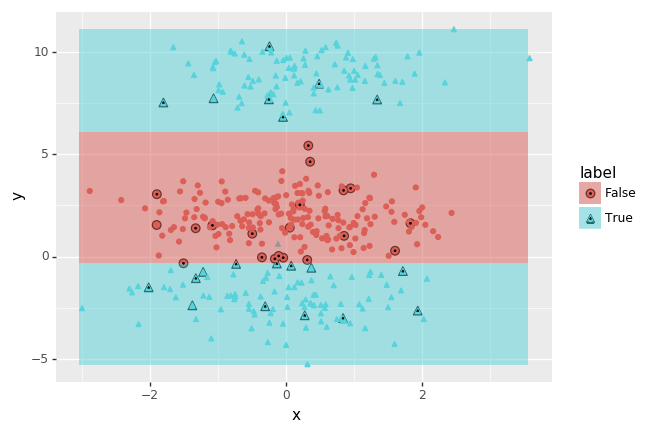

<ggplot: (8764771084250)>

In [24]:
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, tree)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Active learning, biased initial model, RandomForest

In [36]:
initial_sample = data[data.y<5].sample(20)
labeled_initial = initial_sample.index

### Initial model

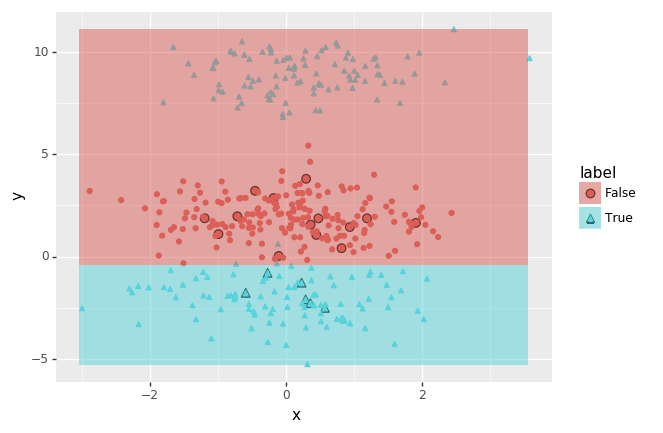

<ggplot: (8764770474574)>

In [37]:
X = initial_sample[['x','y']]
y = initial_sample.label
tree.fit(X,y)
plot_classifier(initial_sample, data, tree)

### After active learning

In [38]:
sample = active_learn(20, initial_sample, data, tree)

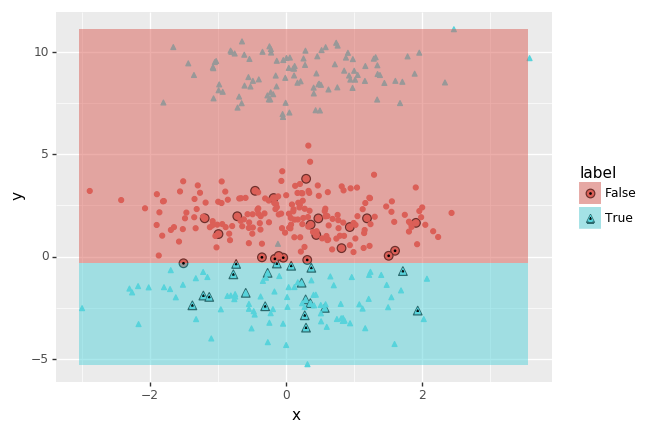

<ggplot: (-9223363272071490679)>

In [39]:
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, tree)+geom_point(selected,aes(x='x',y='y'), size=0.1)

## Active learning, biased initial model, SVC

In [29]:
initial_sample = data[data.y<5].sample(20)

In [30]:
labeled_initial = initial_sample.index
from sklearn.svm import SVC
svm = SVC(probability=True)

### Initial model

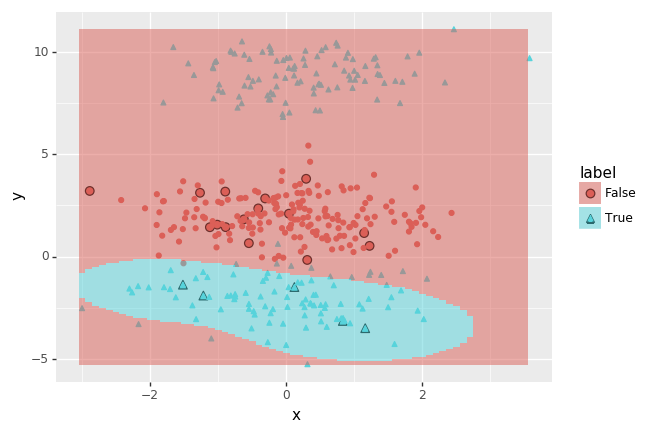

<ggplot: (8764771814141)>

In [31]:
X = initial_sample[['x','y']]
y = initial_sample.label
svm.fit(X,y)
plot_classifier(initial_sample, data, svm)

### After active learning

In [32]:
sample = active_learn(20, initial_sample, data, svm)

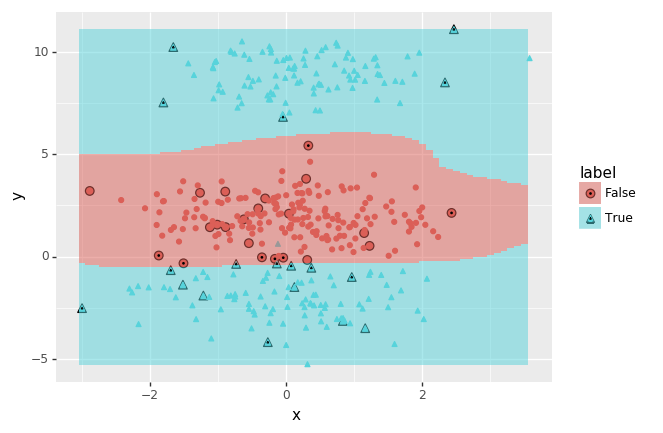

<ggplot: (-9223363272080803079)>

In [33]:
selected = data.loc[sample.index.difference(labeled_initial)]
plot_classifier(sample, data, svm)+geom_point(selected,aes(x='x',y='y'), size=0.1)